# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [2]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

### Define directories and dataset names

In [9]:
### Define directodies and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR + "\\" + 'Sample_Input'
out_path = ROOT_DIR + "\\" + 'Sample_Output'

## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "Copperbelt.gpkg"
adm_col_name = "ADM1_NAME"          ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"

## mines layer
mines_path = in_path + "\\"+ 'mines'
mines_name = 'mines_zambia.gpkg'

In [10]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [11]:
## admininstrative boundary
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)

## mines
mines = gpd.read_file(mines_path + "\\" + mines_name)

## Part 1. Create base grid with H3

### H3 - Hegagon - grid

In [12]:
# Make a copy of the original dataframe (as it might require some changes)
admin_gdf_copy_2 = admin_gdf.buffer(1.245)     ## this is ~15km --> 0.83*1.5

In [13]:
## No of multipolygons in the geometry
#check_geom_type = admin_gdf_copy.geometry.apply(lambda x: list(x))[0]

#len(check_geom_type)

It seems that the geometry is not a polygon but multipolygon. That is, the h3.polyfill will not work. In case the original layer consists of many parts then you shall follow a "merging" approach using a small buffer as described [here](https://gis.stackexchange.com/questions/311931/geopandas-equivalent-of-st-makepolygon/312004#312004). 

However, if polygons are not close this will not work. Thus, the following process (which I do only for one of them) needs to be done for each polygon separately -- unless you write some code to do this automatically! :)

In [14]:
#polygon = check_geom_type[0]
#polygon

In [15]:
#combined = [unary_union(polygon)]
#admin_gdf_copy.geometry = combined

In [16]:
# Convert this to geojson
gj = gpd.GeoSeries([admin_gdf_copy_2.geometry[0]]).__geo_interface__
geoJson = gj['features'][0]['geometry']

In [17]:
size = 7 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = pd.DataFrame(h3.polyfill(geoJson, size), columns=['hexagons'])
hexagons.head()

,hexagons
0,875536a6affffff
1,8755344e8ffffff
2,875534154ffffff
3,87346daf1ffffff
4,875535545ffffff


In [18]:
hexagons['geometry'] = hexagons.hexagons.apply(lambda hex: Polygon(h3.h3_to_geo_boundary(hex)))
hexagons['centeroid'] = hexagons.hexagons.apply(lambda hex: h3.h3_to_geo(hex))

crs = {'init': 'epsg:4326'}

hexagons = gpd.GeoDataFrame(hexagons, crs=crs, geometry=hexagons.geometry)
hexagons['lon'] = hexagons['centeroid'].apply(lambda x: x[0])
hexagons['lat'] = hexagons['centeroid'].apply(lambda x: x[1])

hexagons = hexagons.drop(['centeroid'], axis=1)

display(hexagons.head())

,hexagons,geometry,lon,lat
0,875536a6affffff,"POLYGON ((27.41689 -13.29669, 27.40678 -13.306...",27.404135,-13.292221
1,8755344e8ffffff,"POLYGON ((27.74452 -13.19118, 27.73442 -13.201...",27.731748,-13.186704
2,875534154ffffff,"POLYGON ((27.97517 -12.62383, 27.96512 -12.634...",27.962379,-12.619446
3,87346daf1ffffff,"POLYGON ((29.65933 -12.95820, 29.64923 -12.968...",29.646434,-12.953667
4,875535545ffffff,"POLYGON ((27.20566 -12.08987, 27.19568 -12.100...",27.192927,-12.085617


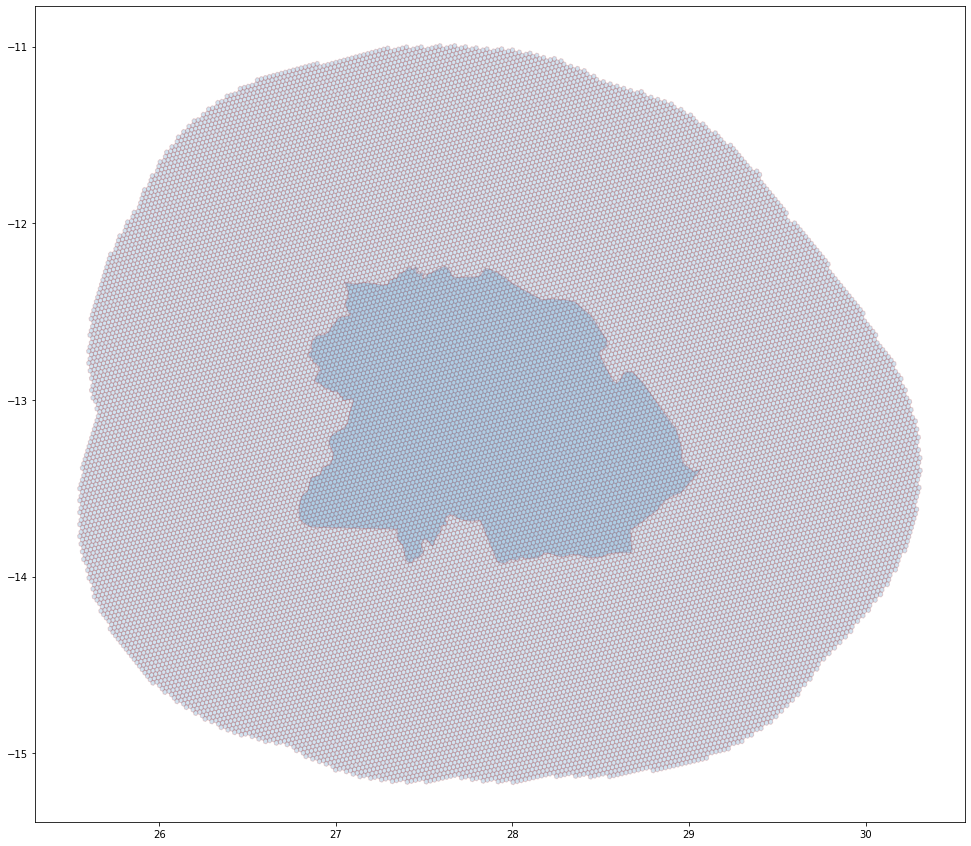

In [19]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [20]:
#Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, admin_gdf[[adm_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[adm_col_name].notnull()]

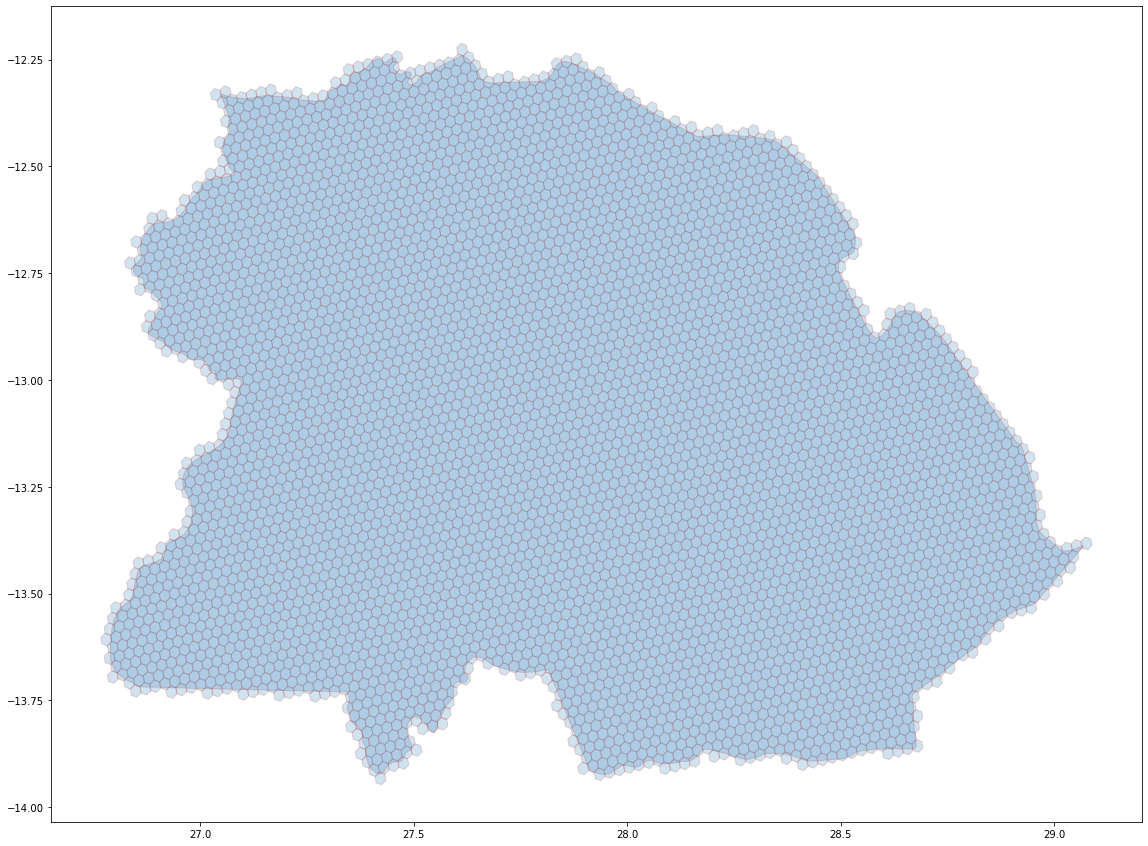

In [21]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [22]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False)

## Step 2. Extract GIS-based attributes

#### Select base map grid and proceed with processing

In [23]:
#hexagons = gpd.read_file(outpath + "\\" + "hex6_with_neighbors.geojson")

In [24]:
grid = hexagons

In [25]:
grid['id'] = range(1, len(grid)+1)

In [26]:
grid.head(3)

,hexagons,geometry,lon,lat,index_right,ADM1_NAME,id
0,875536a6affffff,"POLYGON ((27.41689 -13.29669, 27.40678 -13.306...",27.404135,-13.292221,0.0,COPPERBELT,1
1,8755344e8ffffff,"POLYGON ((27.74452 -13.19118, 27.73442 -13.201...",27.731748,-13.186704,0.0,COPPERBELT,2
2,875534154ffffff,"POLYGON ((27.97517 -12.62383, 27.96512 -12.634...",27.962379,-12.619446,0.0,COPPERBELT,3


### Define extraction functions

In [27]:
def processing_raster(name, method, clusters):
    messagebox.showinfo('OnSSET', 'Select the ' + name + ' map')
    raster=rasterio.open(filedialog.askopenfilename(filetypes = (("rasters","*.tif"),("all files","*.*"))))
    
    clusters = zonal_stats(
        clusters,
        raster.name,
        stats=[method],
        prefix=name, geojson_out=True, all_touched=True)
    
    print(datetime.datetime.now())
    return clusters

In [28]:
def finalizing_rasters(workspace, clusters, crs):
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(clusters)}
        dst.write(json.dumps(collection))
  
    clusters = gpd.read_file(output)
    os.remove(output)
    
    print(datetime.datetime.now())
    return clusters

In [29]:
def spatialjoinvectors(name, column, admin, crs, clusters):
    messagebox.showinfo('OnSSET', 'Select the ' + name + ' map')
    points=gpd.read_file(filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
    
    points_clip = gpd.clip(points, admin)
    points_clip.crs = {'init' :'epsg:4326'}
    points_proj=points_clip.to_crs({ 'init': crs})
    
    gdf_points = points_proj[[column, "geometry"]]
    pointsInPolygon = gpd.sjoin(gdf_points, clusters, how="inner", op='within')
    group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).sum().reset_index()
    clusters = pd.merge(clusters, group_by_name[['id', column]], on='id', how = 'left')
    
    return clusters

## Extract raster values to hexagons

Extract count of buildings per hex

In [30]:
grid = processing_raster("buildings", "count", grid)      #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-02-20 15:43:11.720590


#### ..You can extract values from other raster layers here too..

##### Once done with rasters run this cell

In [33]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-02-20 15:45:14.550320


In [34]:
grid.drop(['index_right'], axis=1, inplace=True)
grid.head(4)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry
0,COPPERBELT,875536a6affffff,1,-13.292221,27.404135,0,"POLYGON ((27.41689 -13.29669, 27.40678 -13.306..."
1,COPPERBELT,8755344e8ffffff,2,-13.186704,27.731748,13,"POLYGON ((27.74452 -13.19118, 27.73442 -13.201..."
2,COPPERBELT,875534154ffffff,3,-12.619446,27.962379,81,"POLYGON ((27.97517 -12.62383, 27.96512 -12.634..."
3,COPPERBELT,875534528ffffff,4,-13.105518,28.052166,18,"POLYGON ((28.06496 -13.10999, 28.05486 -13.120..."


## Extract information from vector layers

Extract sum production of mines in each cluster (hex)

In [35]:
grid = spatialjoinvectors("Mines", 'Commodity Production - tonne (tonnes)', admin_gdf, crs_proj, grid)

In [36]:
grid.head(4)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes)
0,COPPERBELT,875536a6affffff,1,-13.292221,27.404135,0,"POLYGON ((27.41689 -13.29669, 27.40678 -13.306...",NaN
1,COPPERBELT,8755344e8ffffff,2,-13.186704,27.731748,13,"POLYGON ((27.74452 -13.19118, 27.73442 -13.201...",NaN
2,COPPERBELT,875534154ffffff,3,-12.619446,27.962379,81,"POLYGON ((27.97517 -12.62383, 27.96512 -12.634...",NaN
3,COPPERBELT,875534528ffffff,4,-13.105518,28.052166,18,"POLYGON ((28.06496 -13.10999, 28.05486 -13.120...",NaN


# Step 3. Constructing Multi-vector Demand

### Generic fixes (example)

In [37]:
grid['Commodity Production - tonne (tonnes)'] = grid['Commodity Production - tonne (tonnes)'].fillna(0)

In [38]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes)
0,COPPERBELT,875536a6affffff,1,-13.292221,27.404135,0,"POLYGON ((27.41689 -13.29669, 27.40678 -13.306...",0.0
1,COPPERBELT,8755344e8ffffff,2,-13.186704,27.731748,13,"POLYGON ((27.74452 -13.19118, 27.73442 -13.201...",0.0
2,COPPERBELT,875534154ffffff,3,-12.619446,27.962379,81,"POLYGON ((27.97517 -12.62383, 27.96512 -12.634...",0.0


### Calculate Total Demand

**Demand = Residential + Commercial + Industrial (only an EXAMPLE)**

where, 

**Residential** = No of buildings X 50 kWh/building/year  

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production - tonne (tonnes) from mines

In [39]:
grid["Residential"] = grid.apply(lambda row: (row['buildingscount']*50), axis=1)

In [42]:
grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*20 if ((row['buildingscount'] > 100))
                                             else row['buildingscount']*100), axis=1)

In [45]:
grid["TotalDem"] = grid.apply(lambda row: (row['Residential'] + 
                                          row['Commercial'] + 
                                          row['Commodity Production - tonne (tonnes)']), axis=1)

In [46]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Commodity Production - tonne (tonnes),Residential,Commercial,TotalDem
0,COPPERBELT,875536a6affffff,1,-13.292221,27.404135,0,"POLYGON ((27.41689 -13.29669, 27.40678 -13.306...",0.0,0,0,0.0
1,COPPERBELT,8755344e8ffffff,2,-13.186704,27.731748,13,"POLYGON ((27.74452 -13.19118, 27.73442 -13.201...",0.0,650,260,910.0
2,COPPERBELT,875534154ffffff,3,-12.619446,27.962379,81,"POLYGON ((27.97517 -12.62383, 27.96512 -12.634...",0.0,4050,1620,5670.0


In [47]:
grid.TotalDem.sum()

26086200.0

### Export result

In [67]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [68]:
grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG")
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

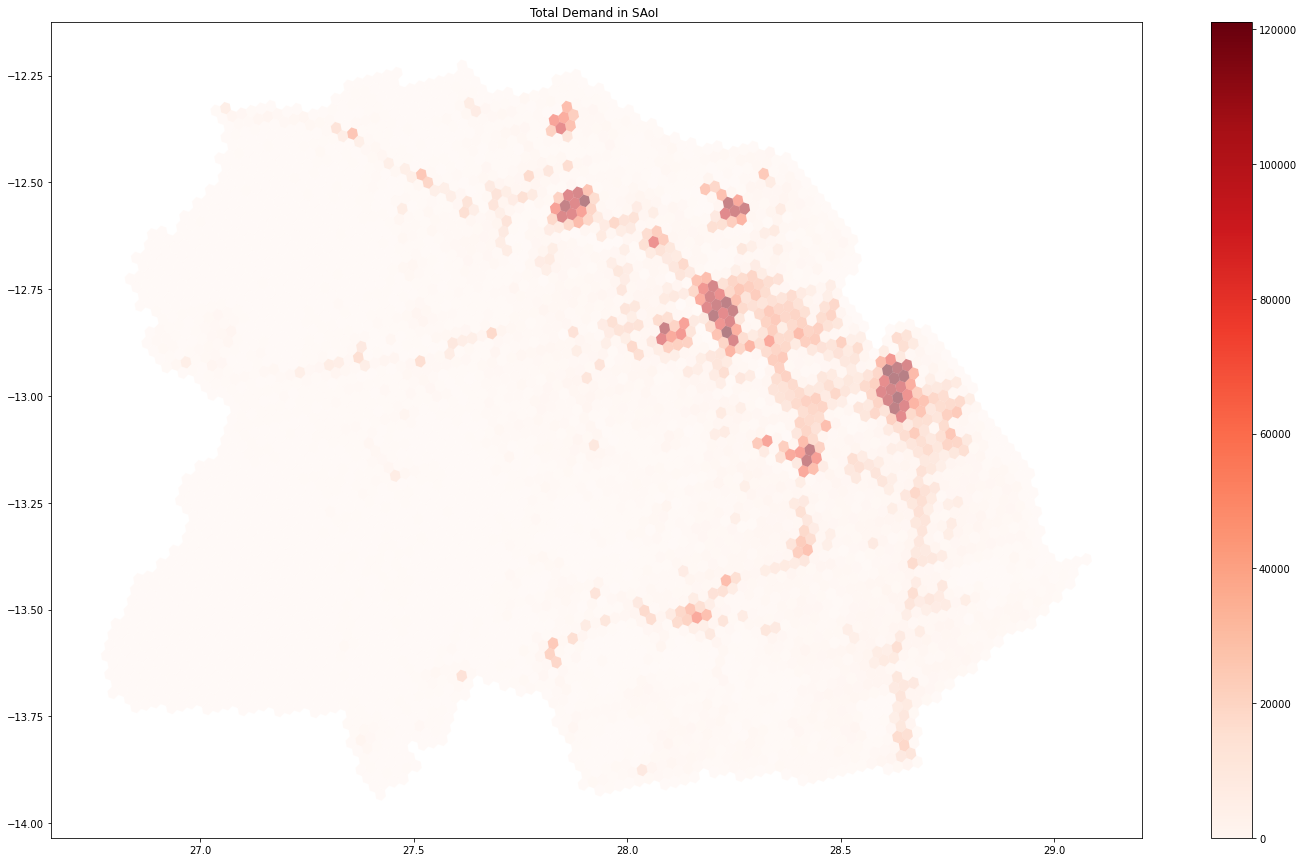

In [49]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Total Demand in {} '.format("SAoI"))

# Save plot as figure 
#plt.savefig('sample_priority_map.png', bbox_inches='tight')